## Wearing A Mask Classifier

This jupyter notebook shows how to train a model to classify a given image into `mask` and `no_mask` indicating whether the image containes a person wearing a face mask. This training process is run on a Nvidia CUDA GPU accelerated machine with Tensorflow 2.2.0 installed.

This training process refers to [Tensorflow Transfer Learning](https://www.tensorflow.org/tutorials/images/transfer_learning)

### Download The Dataset

Download [face mask dataset](https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset) from Kaggle, unzip it, and put the unzipped directory in `dataset` under the directory where this jupyter notebook file locates.

### Part A: Training

We are going to train a model with the face mask dataset. The model will use a pretrained MobileNet V2 model. Using the pretrained model saves the time and resource to train the model while ensuring that the accuracy is high.

In [1]:
import os
import time
from itertools import compress

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.2.0'

In [3]:
# helper function to load images
def load_dataset_tf(path, class_names, train=False, batch_size=128, image_size=(224, 224)):
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    dataset_dir = path
    
    def get_label(file_path):
        # convert the path to a list of path components
        parts = tf.strings.split(file_path, os.path.sep)
        # The second to last is the class-directory
        return parts[-2] == class_names

    def decode_img(img):
        # convert the compressed string to a 3D uint8 tensor
        img = tf.image.decode_jpeg(img, channels=3)
        # Use `convert_image_dtype` to convert to floats in the [0,1] range.
        img = tf.image.convert_image_dtype(img, tf.float32)
        # resize the image to the desired size.
        return tf.image.resize(img, image_size)

    def process_path(file_path):
        label = get_label(file_path)
        # load the raw data from the file as a string
        img = tf.io.read_file(file_path)
        img = decode_img(img)
        return img, label

    dataset = tf.data.Dataset.list_files(os.path.join(dataset_dir, '*/*'))
    dataset = dataset.map(process_path, num_parallel_calls=AUTOTUNE)
    if train:
        dataset = dataset.shuffle(buffer_size=1000)
    # labeled_dataset = labeled_dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

In [4]:
# basic parameters for training
batch_size = 128
image_size = 224
class_names = np.array(['WithoutMask', 'WithMask'])

In [5]:
# load training images
train_dataset = load_dataset_tf('./dataset/Train',
    train=True,
    class_names=class_names,
    batch_size=batch_size,
    image_size=(image_size, image_size))

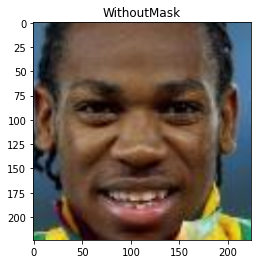

In [6]:
# plot a sample in the training dataset

for image, label in train_dataset.take(1):
    plt.title(list(compress(class_names, label[0]))[0])
    plt.imshow(image[0])

In [7]:
# load validation images
val_dataset = load_dataset_tf('./dataset/Validation',
    class_names=class_names,
    batch_size=batch_size,
    image_size=(image_size, image_size))

In [8]:
# download pretrained MobileNet V2 224 model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(image_size, image_size, 3),
    include_top=False,
    weights='imagenet')

# make the model not trainable
base_model.trainable = False

In [9]:
# print summary of the model
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [10]:
# get the batch of the features
for image_batch, label_batch in train_dataset.take(1):
    pass

print(image_batch.shape)
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(128, 224, 224, 3)
(128, 7, 7, 1280)


In [11]:
# get a layer of global average pooling
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(128, 1280)


In [12]:
# get the output layer
prediction_layer = tf.keras.layers.Dense(2)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(128, 2)


In [13]:
# assemble the model
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [14]:
# print summary of the model
# note that only the last 2 layers will be trained (See Trainable params below)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [15]:
# validate the model before training
validation_steps=7

loss0,accuracy0 = model.evaluate(val_dataset, steps = validation_steps)

7/7 [==============================] - 1s 78ms/step - loss: 0.7658 - accuracy: 0.7337


In [16]:
# train the model with 10 epochs
initial_epochs = 10
history = model.fit(train_dataset,
    epochs=initial_epochs,
    validation_data=val_dataset)

Epoch 1/10
79/79 [==============================] - 6s 76ms/step - loss: 0.4347 - accuracy: 0.9041 - val_loss: 0.2732 - val_accuracy: 0.9400
Epoch 2/10
79/79 [==============================] - 6s 75ms/step - loss: 0.1958 - accuracy: 0.9598 - val_loss: 0.1437 - val_accuracy: 0.9700
Epoch 3/10
79/79 [==============================] - 6s 75ms/step - loss: 0.1107 - accuracy: 0.9745 - val_loss: 0.0883 - val_accuracy: 0.9850
Epoch 4/10
79/79 [==============================] - 6s 75ms/step - loss: 0.0740 - accuracy: 0.9825 - val_loss: 0.0619 - val_accuracy: 0.9900
Epoch 5/10
79/79 [==============================] - 6s 75ms/step - loss: 0.0559 - accuracy: 0.9874 - val_loss: 0.0472 - val_accuracy: 0.9900
Epoch 6/10
79/79 [==============================] - 6s 75ms/step - loss: 0.0452 - accuracy: 0.9890 - val_loss: 0.0383 - val_accuracy: 0.9925
Epoch 7/10
79/79 [==============================] - 6s 75ms/step - loss: 0.0384 - accuracy: 0.9908 - val_loss: 0.0326 - val_accuracy: 0.9937
Epoch 8/10
79

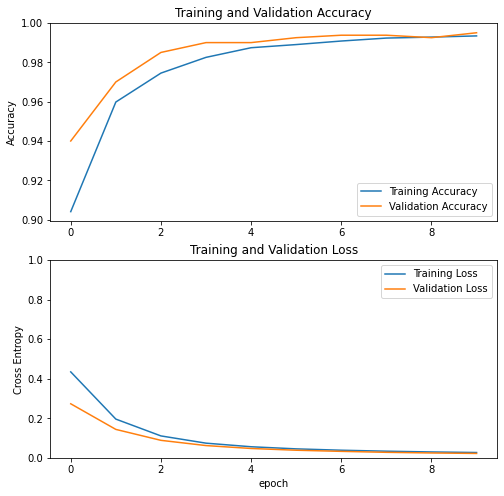

In [17]:
# plot result of the training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [18]:
# load test dataset
test_dataset = load_dataset_tf('./dataset/Test',
    class_names=class_names,
    batch_size=1,
    image_size=(image_size, image_size))

In [19]:
# test the model and see the accuracy
loss0,accuracy0 = model.evaluate(test_dataset)

992/992 [==============================] - 4s 4ms/step - loss: 0.0276 - accuracy: 0.9929


In [20]:
# save the model in the directory
model.save('./mask_classifier_mobilenetv2_224')

# or save it in a file using the HDF5 format
# model.save('./mask_classifier_mobilenetv2_224.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./mask_classifier_mobilenetv2_224/assets


# You are done for training the model!

The training is now completed. You can now build a plugin that loads the saved model to perform inferencing.

### Part B: Fine Tuning The Model

This is an optional, but yet a very important step to improve the trained model. By tuning more parameters in the model, the accuracy can further be improved.

In [21]:
# get the pretrained model
pretrained_layer = model.layers[0]
len(pretrained_layer.layers)
pretrained_layer.trainable = True
fine_tune_at = 100

# freeze all the layers before the `fine_tune_at` layer
for layer in pretrained_layer.layers[:fine_tune_at]:
    layer.trainable = False

In [22]:
# compile the model again with the trainable set to True on some of the layers
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
    metrics=['accuracy'])

In [23]:
# print summary of the model
# Note that about 1.8 million parameters will be trained.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 1,865,154
Non-trainable params: 395,392
_________________________________________________________________


In [24]:
# fine-tune the model
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
    epochs=total_epochs,
    initial_epoch =  history.epoch[-1],
    validation_data=val_dataset)

Epoch 10/20
79/79 [==============================] - 8s 105ms/step - loss: 0.3795 - accuracy: 0.8363 - val_loss: 0.0334 - val_accuracy: 0.9850
Epoch 11/20
79/79 [==============================] - 8s 99ms/step - loss: 0.0389 - accuracy: 0.9899 - val_loss: 0.0301 - val_accuracy: 0.9862
Epoch 12/20
79/79 [==============================] - 8s 100ms/step - loss: 0.0175 - accuracy: 0.9958 - val_loss: 0.0215 - val_accuracy: 0.9887
Epoch 13/20
79/79 [==============================] - 8s 99ms/step - loss: 0.0082 - accuracy: 0.9990 - val_loss: 0.0221 - val_accuracy: 0.9887
Epoch 14/20
79/79 [==============================] - 8s 99ms/step - loss: 0.0056 - accuracy: 0.9990 - val_loss: 0.0179 - val_accuracy: 0.9925
Epoch 15/20
79/79 [==============================] - 8s 99ms/step - loss: 0.0038 - accuracy: 0.9993 - val_loss: 0.0136 - val_accuracy: 0.9912
Epoch 16/20
79/79 [==============================] - 8s 99ms/step - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.0130 - val_accuracy: 0.9925
Epoc

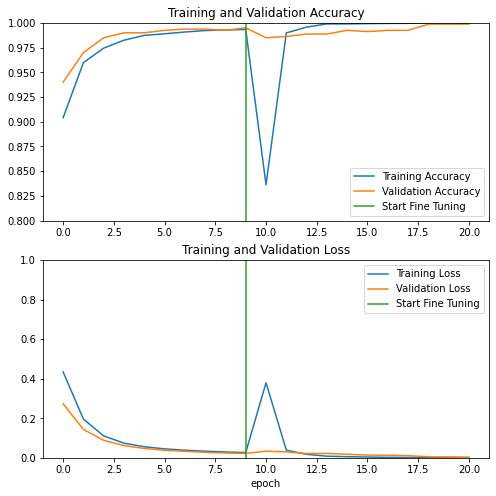

In [25]:
# plot result of the fine tuning
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
# test the model again and see any accuracy improvement
loss0,accuracy0 = model.evaluate(test_dataset)

992/992 [==============================] - 5s 5ms/step - loss: 0.0057 - accuracy: 0.9980


In [27]:
# save the model in the directory
model.save('./mask_classifier_mobilenetv2_224_tuned')

# or save it in a file using the HDF5 format
# model.save('./mask_classifier_mobilenetv2_224_tuned.h5')

INFO:tensorflow:Assets written to: ./mask_classifier_mobilenetv2_224_tuned/assets


### Part C: Converting into Tensorflow Lite

The trained Tensorflow model can be converted into a Tensorflow Lite model with its weight values quantized from float 32 all the way to int 8. This conversion sacrifies the accuracy of the model to gain reduction on the required resource which leads to lighter and faster inferencing. Moreover, it is beneficial when the Tensorflow model is too heavy/large to be run on some edge devices such as Nvidia Jetson Nano.

In [28]:
# load the model
converter = tf.lite.TFLiteConverter.from_saved_model('./mask_classifier_mobilenetv2_224_tuned')

In [29]:
# convert the model into Tensorflow Lite and save it
tflite_model = converter.convert()
with tf.io.gfile.GFile('./mask_classifier_mobilenetv2_224_tuned.tflite', 'wb') as f:
    f.write(tflite_model)

#### Comparing Performance

We measure processing time of the inferencing and compare it between regular Tensorflow model and Tensorflow Lite model.

In [30]:
# helper function to measure performance metric
def run_and_measure(func, func_args, dataset, class_names, skip=3):
    corrected = 0
    elapsed = 0.
    args = func_args
    for index, (image, label) in enumerate(dataset):
        label_name = list(compress(class_names, label[0]))
        label_index = np.where(class_names == label_name)[0][0]
        args.update({'image': image})
        
        start_t = time.time()
        output_data = func(**args)
        if index > skip:
            elapsed += time.time() - start_t
        
        if tf.argmax(output_data, axis=1) == label_index:
            corrected += 1
        # prob = tf.nn.softmax(output_data)[0][label_index]

    np_elapsed = np.array(elapsed)
    print('Total number of inferencing: {:d}'.format(index + 1))
    print('Total elapsed time: {:.3f}'.format(np.sum(np_elapsed)))
    print('Accuracy: {:.2f}'.format(corrected / index))

In [31]:
# load the fine-tuned model
model = tf.keras.models.load_model('./mask_classifier_mobilenetv2_224_tuned')

def infer(model, image):
    return model.predict(image)

# measure performance
run_and_measure(infer, {'model': model}, test_dataset, class_names)

Total number of inferencing: 992
Total elapsed time: 15.351
Accuracy: 1.00


In [33]:
# load the fine-tuned lite model
interpreter = tf.lite.Interpreter(model_path="./mask_classifier_mobilenetv2_224_tuned.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def infer_lite(model, image, input_index, output_index):
    interpreter.set_tensor(input_index, image)
    interpreter.invoke()
    return interpreter.get_tensor(output_index)

run_and_measure(
    infer_lite,
    {
        'model': interpreter,
        'input_index': input_details[0]['index'],
        'output_index': output_details[0]['index']},
    test_dataset,
    class_names)

Total number of inferencing: 992
Total elapsed time: 9.903
Accuracy: 1.00
